# Running simple metrics 

Shapegauss and geometry stability are not included in this notebook. 

Running the entire notebook outputs a file called "data.csv" into the experiments directory

# Which experiments to import for analysis

In [1]:
#Define the path to the experiments directory.
#This directory should contain all the data defined from experiment setup and running
experiment_path = "experiments/"

#This array should contain all the experiments to be analysed.
#These are the directories contained within experimnet_path directory
experiment_names = ["exp_22", "exp_23", "exp_24", "exp_25", "exp_26", "exp_27", "exp_28"]#Paper results
#experiment_names = ["exp_29", "exp_30", "exp_31", "exp_32", "exp_33", "exp_34", "exp_35"]#Additional results

#Linker design
#experiment_names = ["exp_8", "exp_9","exp_10", "exp_11"]
#experiment_names = ["exp_10", "exp_13", "exp_15", "exp_18", "exp_20"]#Looking for molecules to visualise

#All experiments to be analysed
exp_array = [f"{experiment_path}{x}/" for x in experiment_names]

# Create Dataframe

In [2]:
import pandas as pd
import glob

def xyz_to_pd(xyz_path):
    """
    All information from sample XYZ file is parsed into an array
    
    Input (string): file path to XYZ of a molecule generated by SILVR
    
    Output (list): mol_id, xyz, stable_atoms, total_atoms, stable_ratio
        mol_id : name of molecule (molecules are named by their timestamp and GPU)
        xyz : the XYZ data from the sampled molecule
        stable_atoms : the number of stable atoms, determined by bond lengths
        total_atoms : the total number of atoms in the molecule
        stable_ratio : stable_atoms / total_atoms - the ratio of atoms stable by bond lengths
    
    
    """
    mol_id = xyz_path.split("/")[-1].split(".")[0]
    
    with open(xyz_path, "r") as readfile:
        file = readfile.read().split("\n")        
        data = file[1].split(" ")
        
        if data[0].split(":")[1]=="True":
            stable = True
        else:
            stable = True
    
        stable_atoms = int(data[1].split(":")[1])
        total_atoms = int(data[2].split(":")[1])
        stable_ratio = float(data[3].split(":")[1])
        xyz = "\n".join(file)
        
    return [mol_id, xyz, stable_atoms, total_atoms, stable_ratio]

def reference_to_pd(dir_path):
    """
    All information from experiment design reference.sxyz file is parsed and returned as list
    
    input (string path): PATH TO EXPERIMENT DIRECTORY. Note: All experiments MUST constain the reference
        file "reference.sxyz" which defined the full experiment protocol
    
    output (list): [exp_id, xyz, reference_atoms, dummy_atoms, samples, silvr, comment]
        exp_id : name of experiment (given by directory)
        xyz : XYZ coordinates of reference
        reference_atoms : total number of atoms in the reference file
        dummy_atoms : This is not described within the SILVR paper but should be contained in the SI. 
            Dummy atoms are atoms which are added when running the diffusion model (EDM) however are NOT
            MAPPED to a reference atom. That is, the dummy atoms are free to fly around and fit wherever they like.
            This is of particular importance for linker design type generation.
        samples : How many samples to run
        silvr : The silvr rate used in the experiment. If a single value was used for all atoms, the returned value here
            is a single float, however if any of the values are different, this value returns a numpy array. This is
            used when running "selective" experiments, where different atoms recieve a different silvr value depending 
            on priority
        comment : any additional information about the experiment design
    """
    ref_path = dir_path+"reference.sxyz"
    exp_id = ref_path.split("/")[-2]
    
    with open(ref_path,"r") as readfile:
        file = readfile.read().split("\n")
        reference_atoms = int(file[0])
        
        data = file[1].split(" ")
        dummy_atoms = int(data[0].split(":")[1])
        samples = int(data[1].split(":")[1])
        comment = " ".join(data[2:]).split(":")[1]
        
        
        xyz = "\n".join(file)
        
    silvr_data = pd.read_csv(ref_path, delim_whitespace=True, skiprows=2, names=["Element", "X", "Y", "Z", "SILVR"])
    silvr_vector = silvr_data["SILVR"].to_numpy()
    if (silvr_vector[0] == silvr_vector).all():
        silvr = silvr_vector[0]
    else:
        silvr = silvr_vector
    
    #If all values in the array are the same, then just return a float
    
    return [exp_id, xyz, reference_atoms, dummy_atoms, samples, silvr, comment]

In [3]:
#---Import all experiment details into exp_df dataframe------------
#exp_df["exp_id"] is used as a primary key
exp_data = []
for exp in exp_array:
    exp_data.append(reference_to_pd(exp))
exp_df = pd.DataFrame(exp_data,columns=["exp_id", "ref_xyz", "reference_atoms", "dummy_atoms", "samples", "silvr", "comment"])
exp_df.set_index("exp_id")

#---Import all results into results_df----
#results_df["exp_id"] is a foreign key and references exp_df["exp_id"]
results_list = []
for exp in exp_array:
    exp_id = exp.split("/")[-2]
    for xyz in glob.glob(f"{exp}mol_*.txt"):
        results_list.append(xyz_to_pd(xyz)+[exp_id])

results_df = pd.DataFrame(results_list,columns=["mol_id", "xyz", "stable_atoms", "total_atoms", "stable_ratio","exp_id"])
results_df.set_index("mol_id")

#---Merge tables on ["exp_id"]---
#The dataframe df contains all experiment information from xyz and reference.sxyz files
df = pd.merge(results_df,exp_df, on="exp_id")

# RMSD to reference

In [4]:
#https://github.com/charnley/rmsd
#pip install rmsd

import rmsd
import numpy as np

def crude_rmsd(reference, sample, translate=True, rotate=True):
    """
    In this function the reference set of coordinates is compared to the generated sample
    Only XYZ coordinates are compared - no atom identites are considered
    
    I have called this "crude" rmsd because I am not considering the molecular graph
    
    -----method------
    Centering:
        In order to compare SILVR data to control data (SILVR=0.0), all molecules will be centred at the origin 
        (translate=True). Additionally, molecules will be rotated such that RMSD is minimised (rotate=True)
        Both of these options can be turned off by setting the flags to False
    
    Dummy atoms:
        (Dummy atoms are not explicity discussed in the main body of SILVR)
        Dummy atoms must be ignored from the RMSD calculation as there is no direct mapping between
        dummy and reference coordinates. This is implemented within.
        
    ------input/output-------
    Input:
        reference (string) : xyz of reference string block (an XYZ file read into a string)
        sample (string) : xyz of sample string block (an XYZ file read into a string)
        
    output:
        RMSD score (float)
    """
    
    #Ignore first two rows of each string as this contains comments
    reference = reference.rstrip().split("\n")[2:]
    sample = sample.rstrip().split("\n")[2:]
    
    #Only take xyz columns [Element X Y Z SILVR]
    reference = [x.split()[1:4] for x in reference]
    sample = [x.split()[1:4] for x in sample]
    
    n_atoms = len(reference)
    ref_np = np.array(reference)[:n_atoms,:].astype(np.float)
    sample_np = np.array(sample)[:n_atoms,:].astype(np.float)
    
    if translate:
        ref_np -= rmsd.centroid(ref_np)
        sample_np -= rmsd.centroid(sample_np)
        
    if rotate:
            U = rmsd.kabsch(sample_np, ref_np)
            sample_np = np.dot(sample_np, U)
    
    return rmsd.rmsd(ref_np, sample_np)

In [5]:
#Calculated crude RMSD for all samples and their reference
#Remove the RMSD function and instead just calculated manually. No need for the import as it is a single line.
#would need to reference if using this function https://github.com/charnley/rmsd
df["crude_rmsd"] = df.apply(lambda x: crude_rmsd(x['ref_xyz'], x['xyz'],translate=False, rotate=False), axis=1)

/tmp/ipykernel_2414866/528454399.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ref_np = np.array(reference)[:n_atoms,:].astype(np.float)
/tmp/ipykernel_2414866/528454399.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_np = np.array(sample)[:n_atoms,:].astype(np.float)


# Only used for plotting - to be removed

In [6]:
import matplotlib.pyplot as plt

def plot_metric_box(df, exps, metric, ignore_fragmented=False, rdkit_mol=False,title="",ylabel="",xlabel=""):
    
    fig = plt.figure(figsize=(5, 5), dpi=160)
    ax = fig.add_subplot()
    
    if ignore_fragmented:
        selection = df[df["is_fragmented"]==False]
    else:
        selection = df
    if rdkit_mol:
        selection = selection[selection["mol"] != False]

        
    plotting_data = []
    labels = []
    
    for exp in exps:

        metric_value = selection[selection["exp_id"] == exp][metric]
        plotting_data.append(metric_value)
        labels.append(str(selection[selection["exp_id"] == exp]["silvr"].iloc[0]))

    ax.boxplot(plotting_data,labels=labels)

    plt.xlabel(f"{xlabel}")
    plt.ylabel(f"{ylabel}")
    plt.title(f"{title}")
    
    return plt.plot()






def plot_metric_bar(df, exps, metric, ignore_fragmented=False, rdkit_mol=False,title="",ylabel="",xlabel=""):
    
    fig = plt.figure(figsize=(5, 5), dpi=80)
    ax = fig.add_subplot()
    
    if ignore_fragmented:
        selection = df[df["is_fragmented"]==False]
    else:
        selection = df
    if rdkit_mol:
        selection = selection[selection["mol"] != False]

        
    plotting_data = []
    labels = []
    
    for exp in exps:

        metric_value = selection[selection["exp_id"] == exp][metric].mean()
        plotting_data.append(metric_value)
        labels.append(str(selection[selection["exp_id"] == exp]["silvr"].iloc[0]))

    ax.bar(labels, plotting_data)

    plt.xlabel(f"{xlabel}")
    plt.ylabel(f"{ylabel}")
    plt.title(f"{title}")
    
    return plt.plot()

# Create RDKit molecule

In [7]:
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from openbabel import pybel
from rdkit import Chem


def rdkit_fix_radicals(mol,add_h=False,flatten=False,uncharge=True):
    """
    Atoms with unfilled valance get radicals assigned.
    Openbabel will have assigned bond orders based on bond length.
    Here I assume all radical electrons should instead be hydrogen atoms
    """
    for atom in mol.GetAtoms():
        radicals = atom.GetNumRadicalElectrons()
        atom.SetNumRadicalElectrons(0)
        atom.SetNumExplicitHs(atom.GetNumExplicitHs() + radicals)

    if flatten:
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))

    if add_h:
        mol = Chem.AddHs(mol,addCoords=True)

    if uncharge:
        un = rdMolStandardize.Uncharger()
        mol = un.uncharge(mol)

    return mol


def xyz_to_mol_clean(xyz, add_h=True, flatten=False):
    """
    add_h - add RDKit hydrogens
    flatten - run Chem.MolFromSmiles(Chem.MolToSmiles(x)) such that geometry infromation is lost
    
    Sometimes these imports fail
    In these cases this function returns False
    """
    try:
        mol_pybel = pybel.readstring("xyz", xyz)
        mol_mol2 = mol_pybel.write("mol2")

        #RDKit - clean radicals
        mol_rdkit = Chem.MolFromMol2Block(mol_mol2)
        mol_final = rdkit_fix_radicals(mol_rdkit, add_h=add_h, flatten=flatten)

        return mol_final
    
    except:
        return False

In [8]:
#Can take a while
#Seems like this function gets stuck sometimes
#Interupting cell seems to yield a full set of RDKit molecules
df['mol'] = df['xyz'].apply(xyz_to_mol_clean)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

[17:59:06] Running Uncharger
[17:59:06] Removed negative charge.
[17:59:06] Running Uncharger
[17:59:06] Running Uncharger
[17:59:06] Removed negative charge.
[17:59:06] Running Uncharger
[17:59:06] Explicit valence for atom # 13 C, 5, is greater than permitted
[17:59:06] sanitise [17:59:06] stable:False satoms:26 tatoms:31 sratio:0.8387096774193549: [17:59:06] Running Uncharger
[17:59:06] Running Uncharger
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:25 tatoms:31 sratio:0.8064516129032258)

[17:59:06] Running Uncharger
[17:59:06] Removed negative charge.
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:28 tatoms:31 sratio:0.9032258064516129)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:26 tatoms:31 sratio:0.8387096774193549)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:26 tatoms:31 sratio:0.8387096774193549)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title[17:59:07] Running Uncharger
[17:59:07] Running Uncharger
[17:59:07] Removed negative charge.
[17:59:07] Running Uncharger
[17:59:07] Removed negative char

[17:59:07] Running Uncharger
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Running Uncharger
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Can't kekulize mol.  Unkekulized atoms: 6 8 10 13 14
[17:59:07] sanitise [17:59:07] stable:False satoms:29 tatoms:31 sratio:0.9354838709677419: [17:59:07] Running Uncharger
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Running Uncharger
[17:59:07] Removed negative charge.
[17:59:07] Running Uncharger
[17:59:07] Running Uncharger
[17:59:07] Running Uncharger
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Removed negative charge.
[17:59:07] Running Uncharger
[17:59:07] Running Uncharger
[17:59:07] Running Uncharger
[17:59:07] Runn

ol::PerceiveBondOrders (title is stable:False satoms:28 tatoms:31 sratio:0.9032258064516129)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:24 tatoms:31 sratio:0.7741935483870968)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:21 tatoms:31 sratio:0.6774193548387096)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:23 tatoms:31 sratio:0.741935483870967

====
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:19 tatoms:31 sratio:0.6129032258064516)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:30 tatoms:31 sratio:0.967741935483871)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:23 tatoms:31 sratio:0.7419354838709677)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:26 [17:59:08] Running Uncharger
[17:59:08] Removed negative charge.
[17:59:08] Removed negative charge.
[17:59:08] Running Unch

[17:59:09] Running Uncharger
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Running Uncharger
[17:59:09] Running

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:24 tatoms:31 sratio:0.7741935483870968)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:16 tatoms:31 sratio:0.5161290322580645)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:23 tatoms:31 sratio:0.7419354838709677)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:28 tatoms:31 sratio:0.9032258064516129)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:23 tatoms:31 sratio:0.7419354838709677)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[17:59:09] Running Uncharger
[17:59:09] Removed negative charge.
[

[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed

[17:59:10] Running Uncharger
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Explicit valence for atom # 15 C, 5, is greater than permitted
[17:59:10] sanitise [17:59:10] stable:False satoms:19 tatoms:31 sratio:0.6129032258064516: [17:59:10] Explicit valence for atom # 11 C, 5, is greater than permitted
[17:59:10] sanitise [17:59:10] stable:False satoms:15 tatoms:31 sratio:0.4838709677419355: [17:59:10] Running Uncharger
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Removed negative charge.
[17:59:10] Running Uncharger
[17:59:10] Removed negative 

[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:59:11] sanitise [17:59:11] stable:False satoms:15 tatoms:31 sratio:0.4838709677419355: [17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] R

[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Removed negative charge.
[17:59:11] Running Uncharger
[17:59:11] Running Uncharger
[17:59:11] Removed negative charge.
[17:59:11] Explicit valence for atom # 1

to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:27 tatoms:31 sratio:0.8709677419354839)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:20 tatoms:31 sratio:0.6451612903225806)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:25 tatoms:31 sratio:0.8064516129032258)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:25 tatoms:31 sratio:0.8064516129032258)

=====================[17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Running Unch

[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:59:13] sanitise [17:59:13] stable:False satoms:17 tatoms:31 sratio:0.5483870967741935: [17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Removed negative charge.
[17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:25 tatoms:31 sratio:0.8064516129032258)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:20 tatoms:31 sratio:0.6451612903225806)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:26 tatoms:31 sratio:0.8387096774193549)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:[17:59:13] Running Uncharger
[17:59:13] Removed negative charge.
[17:59:13] Explicit valence for atom # 17 C, 5, is greater than permitted
[17:5

[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Explicit valence for atom # 18 C, 5, is greater than permitted
[17:59:14] sanitise [17:59:14] stable:False satoms:15 tatoms:31 sratio:0.4838709677419355: [17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed n

  Failed to kekulize ar[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Explicit valence for atom # 16 C, 5, is greater than permitted
[17:59:14] sanitise [17:59:14] stable:False satoms:17 tatoms:31 sratio:0.5483870967741935: [17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negativ

[17:59:14] sanitise [17:59:14] stable:False satoms:19 tatoms:31 sratio:0.6129032258064516: [17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Explicit valence for atom # 18 C, 5, is greater than permitted
[17:59:14] sanitise [17:59:14] stable:False satoms:12 tatoms:31 sratio:0.3870967741935484: [17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Explicit valence for atom # 19 C, 5, is greater than pe

[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Running Uncharger
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
[17:59:14] Removed negative charge.
 kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:21 tatoms:31 sratio:0.6774193548387096)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:21 tatoms:31 sratio:0.6774193548387096)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromat

[17:59:15] stable:False satoms:6 tatoms:31 sratio:0.1935483870967742: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:15] Running Uncharger
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:15] Running Uncharger
[17:59:15] Removed negative charge.
[17:59:15] stable:False satoms:4 tatoms:31 sratio:0.12903225806451613: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:15] Running Uncharger
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] stable:False satoms:4 tatoms:31 sratio:0.12903225806451613: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation

[17:59:15] Removed negative charge.
[17:59:15] Running Uncharger
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] Removed negative charge.
[17:59:15] Running Uncharger
alse satoms:23 tatoms:31 sratio:0.7419354838709677)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:17 tatoms:31 sratio:0.5483870967741935)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:18 tatoms:31 sratio:0.5806451612903226)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:18 tatoms:31 sratio:0.5806451612903226)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:19 tatoms:31 sratio:0.6129032258064516)

*** Open Babel Wa

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:22 tatoms:31 sratio:0.7096774193548387)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:24 tatoms:31 sratio:0.7741935483870968)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:29 tatoms:31 sratio:0.9354838709677419)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False satoms:16 tatoms:31 sratio:0.5161290322580645)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is stable:False sa[17:59:15] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 file but needed for forma

[17:59:16] Removed negative charge.
[17:59:16] Removed negative charge.
[17:59:16] Removed negative charge.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Removed negative charge.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Running Uncharger
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] stable:False satoms:3 tatoms:31 sratio:0.0967741935483871: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Removed negative charge.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] stable:False satoms:7 tatoms:31 sratio:0.22580645161290322: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Running Unch

[17:59:16] stable:False satoms:10 tatoms:31 sratio:0.3225806451612903: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Removed negative charge.
[17:59:16] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:16] Running Uncharger
[17:59:16] Removed negative charge.
[17:59:16] Removed negative charge.
[17:59:16] stable:False satoms:4 tatoms:31 sratio:0.12903225806451613: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:16] Running Uncharger
[17:59:16] stable:False satoms:4 tatoms:31 sratio:0.12903225806451613: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:16] Running Uncharger
[17:59:16] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 f

[17:59:17] stable:False satoms:2 tatoms:31 sratio:0.06451612903225806: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] Removed negative charge.
[17:59:17] Removed negative charge.
[17:59:17] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] Removed negative charge.
[17:59:17] stable:False satoms:4 tatoms:31 sratio:0.12903225806451613: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] stable:False satoms:9 tatoms:31 sratio:0.2903225806451613: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] Removed negative charge.
[17:59:17] Removed negative charge.
[17:59:17] stable:False satoms:3 tatoms:31 sratio:0.0967741935483871: Warning

[17:59:17] Running Uncharger
[17:59:17] stable:False satoms:6 tatoms:31 sratio:0.1935483870967742: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] Removed negative charge.
[17:59:17] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] Removed negative charge.
[17:59:17] Removed negative charge.
[17:59:17] Removed negative charge.
[17:59:17] stable:False satoms:5 tatoms:31 sratio:0.16129032258064516: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] stable:False satoms:2 tatoms:31 sratio:0.06451612903225806: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:59:17] Running Uncharger
[17:59:17] Removed negative charge.
[17:59:17] Removed negative charge.
[17:59:17] s

In [10]:
#What percentage was successfully read?

failed = len(df[df["mol"]==False])
total = len(df)
print(f"{failed} failed RDKit reads out of {total}")
print(f"Percentage success: {round((total-failed)*100/total, 2)}%")

364 failed RDKit reads out of 7028
Percentage success: 94.82%


# Fragmentation - are RDKit molecules fragmented?

In [11]:
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit import Chem

def is_fragmented(mol, tolerance=None):
    """
    Check if the molecule has been fragmented
    That is, within the RDkit molecule, there are two or more disconnected molecules
    
    Input (RDKit mol): must be RDKit mol object
    
    tolerance (int): can be defined to account for small benign fragments like water
        Molecule is split into fragments. Fragments are a tuple of tuple, with indexes refering to which atoms
        are in which fragment. The length of the tuple indicates the number of atoms in the fragment.
        If the fragment size is larger than the tolerance, the tolerance_counter is incremented. In the case
        where only one fragment is large, and the rest are small, the tolerance_counter will equal 1. If the 
        tolerance_counter is not 1, this means the molecule is fragmented with large fragments. 
        
    Returns (bool): True when the molecule is fragmented
    """
    is_fragmented = False
    fragments = rdmolops.GetMolFrags(mol)
    
    if tolerance:
        tolerance_counter = 0
        for fragment in fragments:
            if len(fragment) > tolerance:
                tolerance_counter += 1
        if tolerance_counter != 1:
            is_fragmented = True
    else:
        if len(fragments) > 1:
            is_fragmented = True
            
    return is_fragmented

In [12]:
df["is_fragmented"] = df[df["mol"]!=False]["mol"].apply(is_fragmented)
df.groupby(["silvr"])["is_fragmented"].value_counts()

silvr   is_fragmented
0.0000  False            585
        True             371
0.0010  False            619
        True             358
0.0025  True             539
        False            445
0.0050  False            515
        True             360
0.0100  False            699
        True             170
0.0200  False            831
        True             168
0.0300  False            904
        True             100
Name: is_fragmented, dtype: int64

In [13]:
df["is_fragmented"] = df[df["mol"]!=False]["mol"].apply(is_fragmented)
df.groupby(["exp_id"])["is_fragmented"].value_counts(True)

exp_id  is_fragmented
exp_22  False            0.611925
        True             0.388075
exp_23  False            0.633572
        True             0.366428
exp_24  True             0.547764
        False            0.452236
exp_25  False            0.588571
        True             0.411429
exp_26  False            0.804373
        True             0.195627
exp_27  False            0.831832
        True             0.168168
exp_28  False            0.900398
        True             0.099602
Name: is_fragmented, dtype: float64

# QED Score - drug likeness score, higher better

In [14]:
from rdkit.Chem import QED
df["qed"] = df[df["mol"]!=False]["mol"].apply(QED.qed)

[17:59:29] WARNING: not removing hydrogen atom without neighbors
[17:59:30] WARNING: not removing hydrogen atom without neighbors
[17:59:31] WARNING: not removing hydrogen atom without neighbors
[17:59:31] WARNING: not removing hydrogen atom without neighbors
[17:59:31] WARNING: not removing hydrogen atom without neighbors
[17:59:32] WARNING: not removing hydrogen atom without neighbors


In [15]:
#plot_metric_box(df, experiment_names, "qed", rdkit_mol=True,title="RDKit QED score ↑",ylabel="QED",xlabel="SILVR rate")

# Synthetic Accessibility - SAscorer - lower better

In [16]:
#http://www.jcheminf.com/content/1/1/8

#-----To install---
#!wget "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/data/zim.100.txt"
#!wget "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/sascorer.py"
#!wget "https://raw.githubusercontent.com/rdkit/rdkit/master/Contrib/SA_Score/fpscores.pkl.gz"

#!mkdir SA_Score/
#!mkdir SA_Score/data

#!mv "zim.100.txt" SA_Score/data/
#!mv "sascorer.py" SA_Score/
#!mv "fpscores.pkl.gz" SA_Score/

In [17]:
from SA_Score import sascorer

#It only makes sense to run this score on whole molecules WITHOUT fragmentation
df['sa'] = df[df["is_fragmented"]==False]['mol'].apply(sascorer.calculateScore)

# Create SMILES string for all molecules - needed for Auto3D

In [18]:
df["smiles"] = df[df["mol"]!=False]["mol"].apply(Chem.MolToSmiles)

# Circular fingerprint (morgan fingerprint)

In [19]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

#to change fingerprint radius, ammend args=(2,)
df["fp"] = df[df["is_fragmented"]==False]["mol"].apply(AllChem.GetMorganFingerprintAsBitVect, args=(2,))

# Principle Component Analysis - still not sure 

In [25]:
# It only makes sense to run this analysis for non fragmented molecules
#Takeing the fingerprint of fragments may give misleading results

from sklearn.decomposition import PCA

#exclude SILVR values
#Might be desired to exclude larger values
#exclude_values = [0.01,0.02,0.03]
exclude_values = []

X = list(df[(~df["silvr"].isin(exclude_values)) & (df["fp"].notnull())]["fp"])
pca = PCA(n_components=2)
components = pca.fit_transform(X)

Text(0, 0.5, 'Principle component 2')

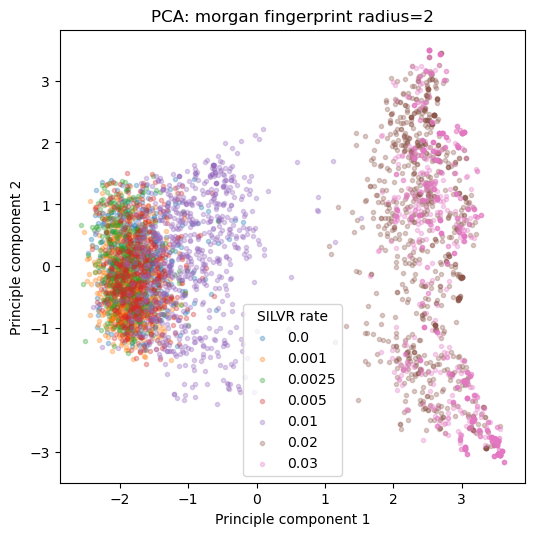

In [26]:
silvr_value = df[(~df["silvr"].isin(exclude_values)) & df["fp"].notnull()]["silvr"]
labels = sorted(silvr_value.unique())

fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot()

for label in labels:
    ax.scatter(components[silvr_value==label][:,0], components[silvr_value==label][:,1], alpha=0.3, label=label, marker=".")
    
ax.legend(title="SILVR rate")
plt.title("PCA: morgan fingerprint radius=2")
plt.xlabel("Principle component 1")
plt.ylabel("Principle component 2")

# Visualise Molecule - with increasing SILVR rate - 3D

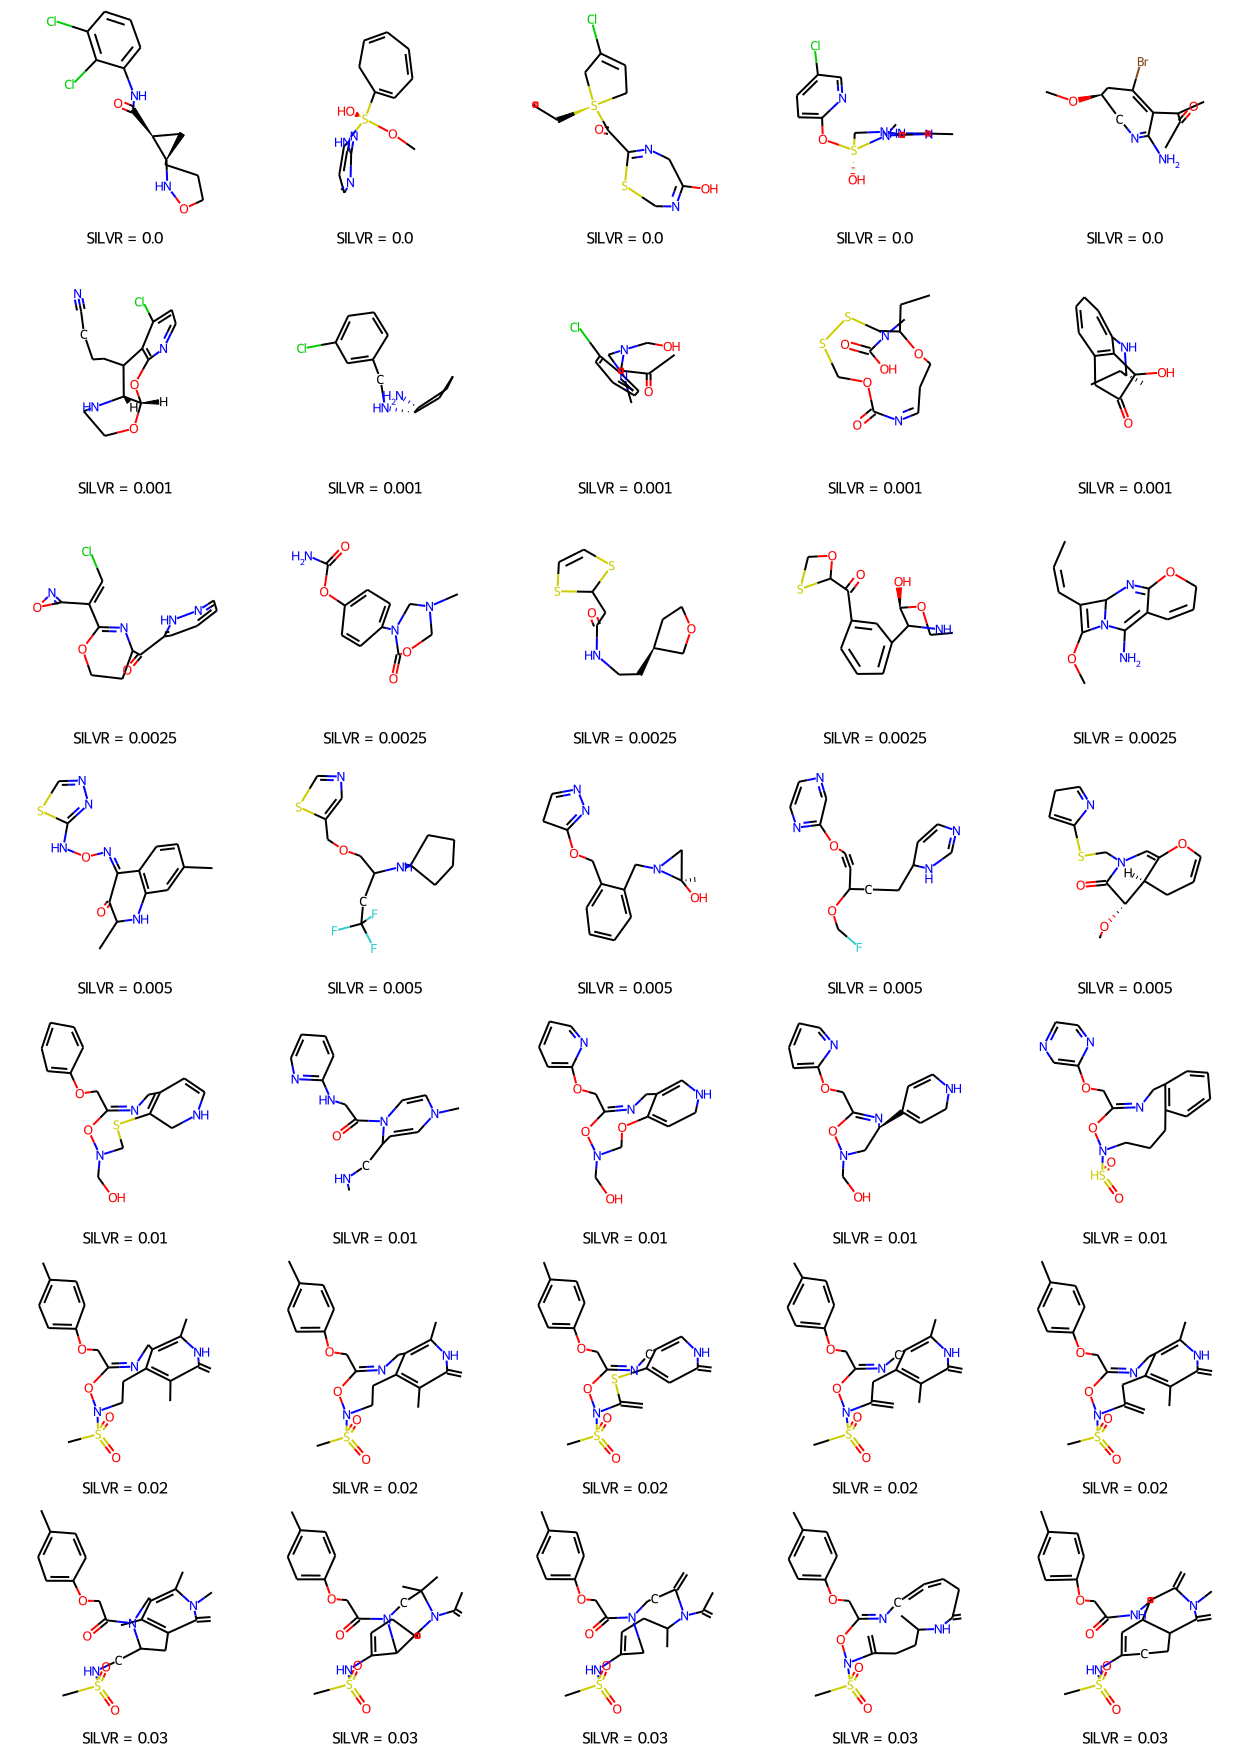

In [38]:
#Select n=molsPerRow molecules from each rate
molsPerRow = 5

#Sort by QED
#Only select non fragmented
#Make 2D
#There is probably a better way to make this array

mols_grid_array = []
legends = []

from rdkit.Chem import rdmolops

for exp in experiment_names:
    #For flat stucture use Chem.MolFromSmiles(Chem.MolToSmiles(x))
    #For no rdmolops.RemoveAllHs(x)
    #For molecule as is us x
    selection = [rdmolops.RemoveAllHs(x) for x in list(df[(df["is_fragmented"]==False) & (df["exp_id"]==exp)].nsmallest(200, "sa").nlargest(100, "qed")["mol"].iloc[:molsPerRow])]
    mols_grid_array += selection
    
    legends += ["SILVR = " + str(exp_df[exp_df["exp_id"]==exp]["silvr"].iloc[0])]*molsPerRow
    
Draw.MolsToGridImage(mols_grid_array, molsPerRow=molsPerRow,
                     #useSVG=True,
                     subImgSize=(250,250),
                     legends=legends
                    )

# Visualise molecules in 2D

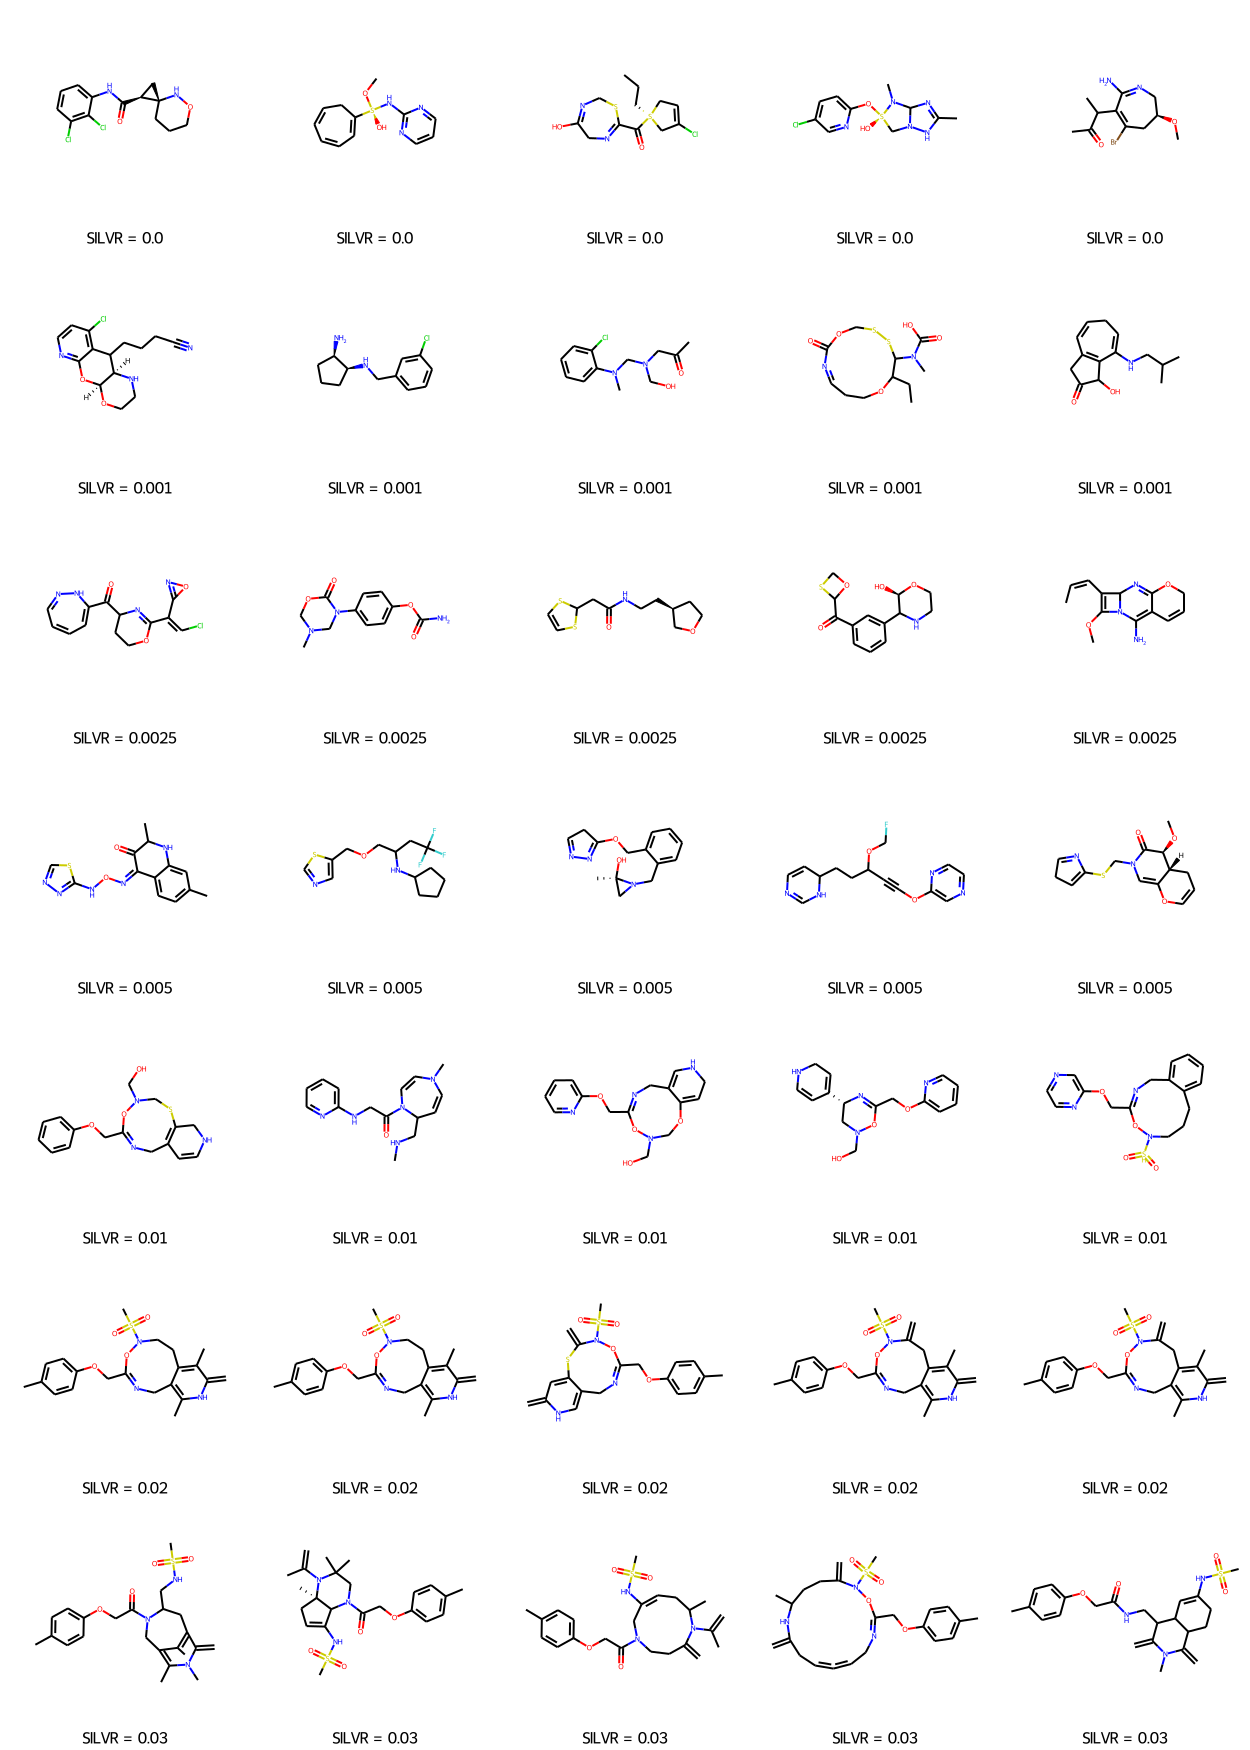

In [39]:
#Select n=molsPerRow molecules from each rate
molsPerRow = 5

#Sort by QED
#Only select non fragmented
#Make 2D

#There is probably a better way to make this array
mols_grid_array = []
legends = []

from rdkit.Chem import rdmolops

for exp in experiment_names:
    #For flat stucture use Chem.MolFromSmiles(Chem.MolToSmiles(x))
    #For no rdmolops.RemoveAllHs(x)
    #For molecule as is us x
    selection = [Chem.MolFromSmiles(Chem.MolToSmiles(rdmolops.RemoveAllHs(x))) for x in list(df[(df["is_fragmented"]==False) & (df["exp_id"]==exp)].nsmallest(200, "sa").nlargest(100, "qed")["mol"].iloc[:molsPerRow])]
    mols_grid_array += selection
    
    legends += ["SILVR = " + str(exp_df[exp_df["exp_id"]==exp]["silvr"].iloc[0])]*molsPerRow
    
Draw.MolsToGridImage(mols_grid_array, molsPerRow=molsPerRow,
                     #useSVG=True,
                     subImgSize=(250,250),
                     legends=legends
                    )

# Save data

In [29]:
columns_to_output = ["mol_id", "total_atoms", "stable_ratio", "exp_id",
                     "dummy_atoms", "samples", "silvr", "comment",
                     "crude_rmsd", "is_fragmented", "qed", "sa", "smiles"]

df[columns_to_output].to_csv(experiment_path+"data_all.csv",index=False)

# Local plotting of metrics - useful for trends etc

In [40]:
#plot_metric_box(df, experiment_names, "stable_ratio", ignore_fragmented=False, rdkit_mol=True,title="",ylabel="",xlabel="")